In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re

# %matplotlib inline
%matplotlib qt
# sns.set_context('paper', font_scale=1.5)

import os, glob
from pathlib import Path
from scipy import stats, interpolate, signal
from scipy.signal import welch, butter, filtfilt
from nolds import sampen
from HelperFcns import *

%load_ext autoreload
%autoreload 2

In [2]:
plt.close('all')

In [3]:
#load poses
path = '/Users/luca/Box/CISPD_Videos_proc/Metadata/'
#load data
df = pd.read_csv(os.path.join(path, 'PosesPat.csv'))
df.index = df['FrameID']
df.head()

,SubjID,Task,cycle,elbR_x,elbR_y,elbR_c,wriR_x,wriR_y,wriR_c,elbL_x,...,midL_c,ringL_x,ringL_y,ringL_c,pinkyL_x,pinkyL_y,pinkyL_c,PersonID,FrameID,NPerson
FrameID,,,,,,,,,,,,,,,,,,,,,
0,1005,FtnL,1,665.729,792.330,0.766920,868.719,836.455,0.802609,786.395,...,0.659051,944.507,532.372,0.632399,944.507,544.356,0.623629,1,0,3
1,1005,FtnL,1,665.653,795.175,0.750911,865.876,836.453,0.808026,789.355,...,0.647635,943.553,532.087,0.596038,942.785,544.374,0.615199,1,1,3
2,1005,FtnL,1,665.679,795.244,0.742167,865.785,836.502,0.809571,792.186,...,0.616394,843.683,413.160,0.822903,861.124,434.393,0.663917,1,2,3
3,1005,FtnL,1,665.627,792.313,0.760414,862.942,836.496,0.815405,792.326,...,0.804164,842.660,412.750,0.849422,858.018,431.180,0.762118,1,3,3
4,1005,FtnL,1,665.620,795.171,0.755462,862.911,836.500,0.817131,795.149,...,0.656123,843.071,412.394,0.805221,860.170,431.824,0.758662,1,4,3


In [4]:
#load scores
# scores = pd.read_csv('/Users/luca/Box/CISPD_Videos_proc/Metadata/Table4.csv')
tasks = ['FtnL', 'FtnR']
scores = pd.read_csv(path+'/Table4.csv')
scores = scores.loc[(scores['SubjID'].isin(df.SubjID.unique())) & (scores.TaskAbb.isin(tasks))]
scores = scores[['SubjID','Visit','TaskAbb','Tremor - Left', 'Tremor - Right', 
                 'Bradykinesia - Right', 'Bradykinesia - Left','Dyskinesia - Left','Dyskinesia - Right']]
scores.rename(columns={'Tremor - Right':'Tremor - R', 'Tremor - Left':'Tremor - L',
                      'Bradykinesia - Right': 'Bradykinesia - R',
                      'Bradykinesia - Left': 'Bradykinesia - L',
                      'Dyskinesia - Left': 'Dyskinesia - L',
                      'Dyskinesia - Right': 'Dyskinesia - R'}, inplace=True)
scores.query('Visit != "1 Month"', inplace=True)
scores['Visit']=scores.Visit.apply(lambda x: x.split()[-1])
for i,j in enumerate(scores.Visit.unique()):
    print(i,j)
    scores.loc[scores.Visit==j, 'Visit'] = i+1
scores = scores.query('Visit ==1 | Visit ==2 | Visit==3')
scores.head(2)

0 0
1 30
2 60
3 90
4 120
5 150


,SubjID,Visit,TaskAbb,Tremor - L,Tremor - R,Bradykinesia - R,Bradykinesia - L,Dyskinesia - L,Dyskinesia - R
213,1005,1,FtnL,1.0,0.0,NaN,2.0,0.0,0.0
214,1005,1,FtnR,1.0,0.0,0.0,NaN,0.0,0.0


In [5]:
scores.SubjID.unique()

array([1005, 1007, 1009, 1016, 1018, 1019, 1020, 1023, 1024, 1029, 1030,
       1032, 1038, 1039, 1043, 1044, 1046, 1047, 1049, 1050, 1051, 1052,
       1053, 1054, 1055, 1056])

In [6]:
scores.query('TaskAbb=="FtnR"').iloc[:,3:].plot(kind='hist', subplots=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9f9ff69350>,
      dtype=object)

In [73]:
# sum((scores.iloc[:,-2:] > 0).any())
# scores[(scores.iloc[:,-2:] > 0)]

,SubjID,Visit,TaskAbb,Tremor - L,Tremor - R,Bradykinesia - R,Bradykinesia - L,Dyskinesia - L,Dyskinesia - R
213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
228,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
229,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
243,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2869,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
2883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2884,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
2898,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Compute features for both sides

In [7]:
#compute scores for both sides
F_all = pd.DataFrame()
for subj, cycle in (scores[['SubjID','Visit']].values).tolist():
    print(subj,cycle)
    for side in ['R','L']:     
        task = 'Ftn'+side
        #compute distance from body landmark
        try:
            x = dist_from_ref(df, subj, cycle=cycle, side=side, task=task)
        except:
            print('cannot compute joint displacement - dist_from_ref failed')
            continue
        if x is not None:
            F = compute_features_oneside(x, winlen=10, overlap=0.5)
            #merge scores with features table
            sdf = scores.query('SubjID==@subj & Visit==@cycle & TaskAbb==@task')
            F['SubjID'] = subj 
            F['Cycle'] = cycle 
            F['Tremor'] = sdf['Tremor - '+side].values[-1]
            F['Bradykinesia'] = sdf['Bradykinesia - '+side].values[-1]    
            F['side'] = side
            F_all = pd.concat((F_all, F),axis=0)
        
F_all['total_score'] = F_all.Tremor + F_all.Bradykinesia
F_all.dropna(inplace=True)
print(F_all.total_score.unique())

1005 1
1005 1
1005 2
1005 2
1005 3
no joint data found
no joint data found
1005 3
no joint data found
no joint data found
1007 1
no joint data found
1007 1
no joint data found
1007 2
no joint data found
no joint data found
1007 2
no joint data found


/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


no joint data found
1007 3
no joint data found
1007 3
no joint data found
1009 1
no joint data found
1009 1
no joint data found
1009 2
no joint data found
no joint data found
1009 2
no joint data found
no joint data found
1009 3
1009 3
1016 1
no joint data found
1016 1
no joint data found
1016 2
no joint data found
no joint data found
1016 2
no joint data found
no joint data found
1016 3
1016 3
1018 1
no joint data found
1018 1
no joint data found
1018 2
no joint data found
no joint data found
1018 2
no joint data found
no joint data found
1018 3
no joint data found
1018 3
no joint data found
1019 1
1019 1
1019 2
no joint data found
no joint data found
1019 2
no joint data found
no joint data found
1019 3
1019 3
1020 1
no joint data found
1020 1
no joint data found
1020 2
no joint data found
no joint data found
1020 2
no joint data found
no joint data found
1020 3
1020 3
1023 1
savgol filter did not converge
1023 1
savgol filter did not converge
1023 2
no joint data found
no joint data

/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


cannot compute joint displacement - dist_from_ref failed
1038 1
no joint data found
1038 1
no joint data found
1038 2
no joint data found
no joint data found
1038 2
no joint data found
no joint data found
1038 3
1038 3
1039 1
1039 1
1039 2
no joint data found
no joint data found
1039 2
no joint data found
no joint data found
1039 3
1039 3
1043 1
1043 1
1043 2
no joint data found
no joint data found
1043 2
no joint data found
no joint data found
1043 3
1043 3
1044 1
no joint data found
1044 1
no joint data found
1044 2
no joint data found
no joint data found
1044 2
no joint data found
no joint data found
1044 3
no joint data found
1044 3
no joint data found
1046 1
no joint data found
no joint data found
1046 1
no joint data found
no joint data found
1046 2
no joint data found
no joint data found
1046 2
no joint data found
no joint data found
1046 3
1046 3
1047 1
1047 1
1047 2
no joint data found
no joint data found
1047 2
no joint data found
no joint data found
1047 3
1047 3
1049 1
1049

In [8]:
F_all.columns

Index(['F_dom', 'F_dom_ratio', 'spd_var', 'entropy_psd', 'SubjID', 'Cycle',
       'Tremor', 'Bradykinesia', 'side', 'total_score'],
      dtype='object')

In [9]:
F_all.groupby(['SubjID'])['Cycle'].unique()

SubjID
1005    [1, 2]
1007    [1, 3]
1009    [1, 3]
1016    [1, 3]
1018    [1, 3]
1019    [1, 3]
1023    [1, 3]
1024    [1, 3]
1029    [1, 3]
1030    [1, 3]
1032    [1, 3]
1038    [1, 3]
1039    [1, 3]
1043    [1, 3]
1044    [1, 3]
1046       [3]
1047    [1, 3]
1049    [1, 3]
1050       [2]
1051    [1, 3]
1054       [3]
1055    [1, 3]
1056    [1, 2]
Name: Cycle, dtype: object

In [10]:
plt.close('all')

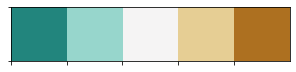

In [35]:
%matplotlib inline
sequential_colors = sns.color_palette('BrBG_r',5)
# sequential_colors = sns.color_palette('OrRd',5)
sns.palplot(sequential_colors)

In [11]:
#plot features - sum tremor and bradykinesia scores
%matplotlib qt
sns.set_context('talk', font_scale=.75)
g = sns.pairplot(F_all.drop(labels=['SubjID', 'Tremor', 'Bradykinesia', 'Cycle', 'F_dom_ratio'],axis=1), hue='total_score', 
             plot_kws=dict(alpha=0.8), diag_kind='kde', palette=sequential_colors)
plt.tight_layout()
g._legend.set_bbox_to_anchor((0.4, 0.85))

In [17]:
#plot features - med state
colors = ['pale red','medium green']
binary_pal = sns.xkcd_palette(colors)

#OFF/ON based on symptom presence - Binary classification
F_all['medication_state'] = 'ON'
F_all.loc[((F_all.Bradykinesia > 0) | (F_all.Tremor > 0)), 'medication_state'] = 'OFF'

#OFF/ON based on medication state - need to check medical notes
# F_all['medication_state'] = 'OFF'
# F_all.loc[F_all.Cycle >= 3, 'medication_state'] = 'ON'

%matplotlib qt
sns.pairplot(F_all.drop(labels=['SubjID','Cycle', 'side', 'Tremor', 'Bradykinesia', 'total_score'],axis=1), 
             hue='medication_state', 
             plot_kws=dict(alpha=0.5), diag_kind='kde', palette=binary_pal)
plt.tight_layout()

In [140]:
#plot features - bradykinesia only
%matplotlib qt
sns.pairplot(F_all.drop(labels=['SubjID', 'Tremor', 'total_score'],axis=1), hue='Bradykinesia', 
             plot_kws=dict(alpha=0.5), diag_kind='hist', palette=sequential_colors)
plt.tight_layout()

# Gaussian Naive Bayes Score

We could use individual features to show the variability in MDS scores by different raters (need to get more raters). Then train a naive Bayes model on the features to get a combined score and show the distribution of subject scores relative to the rater scores (or alternatively could use a clustering - unsupervised approach)


Storyline:
1) supervised approach - hand movements - low novelty 
2) semi-supervised - show how current featuers correlate with MDS scores. Train naive Bayes to get a combined score (probably need a rater)
3) unsupervised 

Two main ideas: a) extract explainable features from videos; b) show correlation with MDS scores c) combine features using Naive Bayes to provide more sensitive measure and avoid issue of biased raters 


In [11]:
# features = ['F_dom', 'spd_var', 'entropy_psd']
features = ['F_dom', 'spd_var']
F_all.reset_index(drop=True,inplace=True)
# F_all.drop('F_dom_ratio',axis=1,inplace=True)
F_all_grouped = F_all.groupby(['SubjID','Cycle','side']).mean()

In [13]:
zero_scores = F_all_grouped[F_all_grouped['total_score'] == 0]
zero_scores.head()

F_dom  F_dom_ratio   spd_var  entropy_psd  Tremor  \
SubjID Cycle side                                                         
1005   1     R     1.196013     0.568051  0.103879     0.228029     0.0   
       2     R     1.146179     0.509701  0.072169     0.251847     0.0   
1007   1     L     0.717608     0.552229  0.064441     0.222243     0.0   
       3     L     0.722591     0.552795  0.073985     0.224777     0.0   
1009   3     L     1.046512     0.585088  0.091062     0.213614     0.0   

                   Bradykinesia  total_score  
SubjID Cycle side                             
1005   1     R              0.0          0.0  
       2     R              0.0          0.0  
1007   1     L              0.0          0.0  
       3     L              0.0          0.0  
1009   3     L              0.0          0.0

0 F_dom
1 spd_var


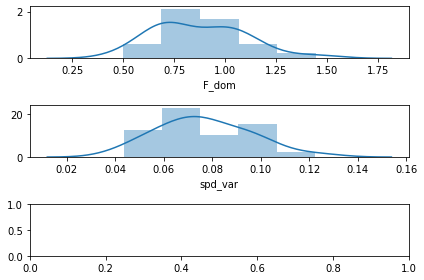

In [14]:
#distribution of features
%matplotlib inline
fig,ax =plt.subplots(3,1); ax=ax.ravel()
for i,f in enumerate(features):
    print(i,f)
    sns.distplot(zero_scores[f],ax=ax[i])
plt.tight_layout()

In [16]:
pi=np.pi
#input feature vector, outputs gnb for that instance
def gnb_raw(x, params):
    neg_logp = neg_logp = (0.5*np.log(2*pi) + 0.5*((x - params.mu)**2/params.sigma**2))
    return neg_logp.sum()

#ref population parameters
mu_ref = zero_scores[features].mean()
sigma_ref = zero_scores[features].std()
params = pd.DataFrame({'mu':mu_ref, 'sigma':sigma_ref})
# print(mu_ref.shape, sigma_ref.shape)
print(params)

               mu     sigma
F_dom    0.875216  0.221729
spd_var  0.076671  0.018883


In [17]:
zero_scores['gnb']=zero_scores[features].apply(gnb_raw, axis=1, args=(params,))
zero_scores.head()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


F_dom  F_dom_ratio   spd_var  entropy_psd  Tremor  \
SubjID Cycle side                                                         
1005   1     R     1.196013     0.568051  0.103879     0.228029     0.0   
       2     R     1.146179     0.509701  0.072169     0.251847     0.0   
1007   1     L     0.717608     0.552229  0.064441     0.222243     0.0   
       3     L     0.722591     0.552795  0.073985     0.224777     0.0   
1009   3     L     1.046512     0.585088  0.091062     0.213614     0.0   

                   Bradykinesia  total_score       gnb  
SubjID Cycle side                                       
1005   1     R              0.0          0.0  3.922560  
       2     R              0.0          0.0  2.613006  
1007   1     L              0.0          0.0  2.300247  
       3     L              0.0          0.0  2.084898  
1009   3     L              0.0          0.0  2.426717

In [19]:
#to normalize the surprise score
mu_psi = zero_scores['gnb'].mean()
std_psi = zero_scores['gnb'].std()
print(mu_psi, std_psi)

zero_scores['gnb_norm'] = 0
zero_scores['gnb'] = zero_scores[features].apply(gnb_raw, axis=1, args=(params,))
zero_scores['gnb_norm'] = zero_scores['gnb'].apply(lambda x:(x-mu_psi)/std_psi) 

2.7978770664093453 0.8901042508810463


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

In [21]:
#calculate score of other participants relative to normative
pos_scores = F_all_grouped[F_all_grouped['total_score'] > 0]
pos_scores['gnb'] = pos_scores[features].apply(gnb_raw, axis=1, args=(params,))
pos_scores['gnb_norm'] = pos_scores['gnb'].apply(lambda x:(x-mu_psi)/std_psi) 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [22]:
pos_scores.head()

F_dom  F_dom_ratio   spd_var  entropy_psd  Tremor  \
SubjID Cycle side                                                         
1005   2     L     0.797342     0.565561  0.022927     0.218580     2.0   
1009   1     L     0.697674     0.623755  0.067041     0.218233     0.0   
1016   1     R     0.797342     0.524836  0.068427     0.277475     0.0   
       3     R     0.897010     0.606563  0.074215     0.238470     1.0   
1018   1     L     0.598007     0.574428  0.048388     0.192890     1.0   

                   Bradykinesia  total_score       gnb  gnb_norm  
SubjID Cycle side                                                 
1005   2     L              2.0          4.0  5.949882  3.541164  
1009   1     L              1.0          1.0  2.288503 -0.572263  
1016   1     R              1.0          1.0  1.994867 -0.902153  
       3     R              0.0          1.0  1.851167 -1.063594  
1018   1     L              1.0          2.0  3.741092  1.059667

In [23]:
all_gnb = pd.concat((zero_scores,pos_scores),axis=0)

In [113]:
plt.figure()
sns.regplot(data=all_gnb, x='total_score', y='gnb_norm')
plt.axhline(y=2, c='orange', linestyle='--')
plt.tight_layout()

In [27]:
all_gnb = all_gnb.reset_index()
all_gnb

,SubjID,Cycle,side,F_dom,F_dom_ratio,spd_var,entropy_psd,Tremor,Bradykinesia,total_score,gnb,gnb_norm
0,1005,1,R,1.196013,0.568051,0.103879,0.228029,0.0,0.0,0.0,3.922560,1.263541
1,1005,2,R,1.146179,0.509701,0.072169,0.251847,0.0,0.0,0.0,2.613006,-0.207696
2,1007,1,L,0.717608,0.552229,0.064441,0.222243,0.0,0.0,0.0,2.300247,-0.559070
3,1007,3,L,0.722591,0.552795,0.073985,0.224777,0.0,0.0,0.0,2.084898,-0.801006
4,1009,3,L,1.046512,0.585088,0.091062,0.213614,0.0,0.0,0.0,2.426717,-0.416985
...,...,...,...,...,...,...,...,...,...,...,...,...
62,1055,3,L,0.863787,0.495407,0.063613,0.247761,2.0,1.0,3.0,2.078328,-0.808387
63,1056,1,L,0.498339,0.579343,0.052525,0.252680,2.0,2.0,4.0,4.100008,1.462897
64,1056,1,R,0.474425,0.534261,0.053882,0.300234,2.0,1.0,3.0,4.199775,1.574982
65,1056,2,L,0.598007,0.523300,0.047884,0.303070,2.0,2.0,4.0,3.781478,1.105041


In [70]:
all_gnb['medication state'] = 'OFF'
all_gnb.loc[all_gnb.Cycle > 1, 'medication state'] = 'ON'
all_gnb.head()

,SubjID,Cycle,side,F_dom,F_dom_ratio,spd_var,entropy_psd,Tremor,Bradykinesia,total_score,gnb,gnb_norm,medication state,medication_state
0,1005,1,R,1.196013,0.568051,0.103879,0.228029,0.0,0.0,0.0,3.922560,1.263541,OFF,OFF
1,1005,2,R,1.146179,0.509701,0.072169,0.251847,0.0,0.0,0.0,2.613006,-0.207696,ON,ON
2,1007,1,L,0.717608,0.552229,0.064441,0.222243,0.0,0.0,0.0,2.300247,-0.559070,OFF,OFF
3,1007,3,L,0.722591,0.552795,0.073985,0.224777,0.0,0.0,0.0,2.084898,-0.801006,ON,ON
4,1009,3,L,1.046512,0.585088,0.091062,0.213614,0.0,0.0,0.0,2.426717,-0.416985,ON,ON


In [101]:
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0.1, ls='-')
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rcParams['axes.grid'] = True
# plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts


In [110]:
# sequential_colors = sns.color_palette('BrBG_r',5)
# %matplotlib qt
plt.figure()
y = 'gnb_norm'
sequential_colors = sns.color_palette('OrRd',4)
palette=sequential_colors
sns.set_context('talk', font_scale=1)
fig, ax = plt.subplots(1,3, figsize=(15,15))
sns.stripplot(data=all_gnb, x='medication state', y=y, hue='Bradykinesia', 
                 palette=sns.color_palette('OrRd',len(all_gnb.Bradykinesia.unique())), 
                s=10, ax=ax[0], alpha=.8)
ax[0].set_ylabel('z-score')
sns.stripplot(data=all_gnb, x='medication state', y=y, hue='Tremor', 
                 palette=sns.color_palette('OrRd',len(all_gnb.Tremor.unique())), 
                s=10, ax=ax[1])
ax[1].set_ylabel('z-score')

sns.stripplot(data=all_gnb, x='medication state', y=y, hue='total_score', 
                palette=sns.color_palette('OrRd',len(all_gnb['total_score'].unique())), 
                s=10, ax=ax[2])
ax[2].set_ylabel('z-score')

plt.tight_layout()
sns.despine()
# plt.grid()

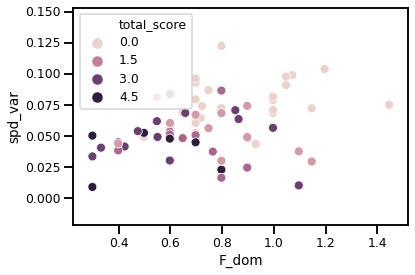

In [75]:
plt.figure()
sns.scatterplot(data=all_gnb, x='F_dom',y='spd_var', hue='total_score')

In [108]:
all_gnb.query('total_score>2')

,SubjID,Cycle,side,F_dom,F_dom_ratio,spd_var,entropy_psd,Tremor,Bradykinesia,total_score,gnb,gnb_norm,medication state,medication_state
25,1005,2,L,0.797342,0.565561,0.022927,0.218580,2.0,2.0,4.0,5.949882,3.541164,ON,ON
31,1019,1,L,0.332226,0.497007,0.040611,0.277815,1.0,2.0,3.0,6.659822,4.338756,OFF,OFF
36,1024,1,L,1.096346,0.337692,0.010300,0.480470,2.0,1.0,3.0,8.512330,6.419981,OFF,OFF
44,1032,1,R,0.548173,0.495370,0.061895,0.223738,1.0,2.0,3.0,3.231826,0.487526,OFF,OFF
46,1038,1,L,0.299003,0.386851,0.050288,0.387494,3.0,1.0,4.0,6.190663,3.811672,OFF,OFF
47,1038,3,L,0.398671,0.601107,0.044974,0.218129,3.0,0.0,3.0,5.556303,3.098992,ON,ON
48,1038,3,R,0.423588,0.558529,0.041549,0.246421,2.0,1.0,3.0,5.642036,3.195310,ON,ON
52,1043,1,L,0.598007,0.618686,0.030325,0.207963,0.0,3.0,3.0,5.631488,3.183460,OFF,OFF
53,1043,1,R,0.697674,0.456179,0.044912,0.295674,1.0,3.0,4.0,3.572882,0.870690,OFF,OFF
55,1049,1,L,0.299003,0.376305,0.009041,0.347615,2.0,2.0,4.0,11.628396,9.920770,OFF,OFF


In [104]:
all_gnb.query('total_score > 1')

,SubjID,Cycle,side,F_dom,F_dom_ratio,spd_var,entropy_psd,Tremor,Bradykinesia,total_score,gnb,gnb_norm,medication state,medication_state
25,1005,2,L,0.797342,0.565561,0.022927,0.218580,2.0,2.0,4.0,5.949882,3.541164,ON,ON
29,1018,1,L,0.598007,0.574428,0.048388,0.192890,1.0,1.0,2.0,3.741092,1.059667,OFF,OFF
30,1018,3,L,0.647841,0.564423,0.048275,0.213735,1.0,1.0,2.0,3.494392,0.782509,ON,ON
31,1019,1,L,0.332226,0.497007,0.040611,0.277815,1.0,2.0,3.0,6.659822,4.338756,OFF,OFF
33,1023,1,L,0.797342,0.310476,0.086513,0.535067,1.0,1.0,2.0,2.035383,-0.856635,OFF,OFF
34,1023,1,R,0.797342,0.426213,0.016432,0.311139,1.0,1.0,2.0,6.988040,4.707497,OFF,OFF
36,1024,1,L,1.096346,0.337692,0.010300,0.480470,2.0,1.0,3.0,8.512330,6.419981,OFF,OFF
38,1029,1,L,0.764120,0.525886,0.037470,0.243740,2.0,0.0,2.0,4.118355,1.483510,OFF,OFF
39,1029,1,R,0.697674,0.540792,0.050613,0.252482,2.0,0.0,2.0,3.110629,0.351365,OFF,OFF
42,1030,1,L,0.598007,0.519998,0.053381,0.289133,1.0,1.0,2.0,3.380032,0.654030,OFF,OFF


In [93]:
# zero_scores[features].groupby('SubjID').mean() #reference feature values per subject

In [18]:
#build classifier


In [100]:
#features on one side only
# F_all = pd.DataFrame()
# for subj, cycle in (scores[['SubjID','Visit']].values).tolist():
#     print(subj,cycle)
#     #compute distance from body landmark
#     x = dist_from_ref(df, subj, cycle=cycle, side='R', task='FtnR')
#     if x is not None:
#         F = compute_features_oneside(x, winlen=5, overlap=0.5)
#         #merge scores with features table
#         sdf = scores.query('SubjID==@subj & Visit==@cycle')
#         F['SubjID'] = subj 
#         F['Tremor'] = sdf['Tremor - R'].values[-1]
#         F['Bradykinesia'] = sdf['Bradykinesia - R'].values[-1]      
#         F_all = pd.concat((F_all, F),axis=0)
        
# F_all['total_score'] = F_all.Tremor + F_all.Bradykinesia
# F_all.dropna(inplace=True)
# print(F_all.total_score.unique())

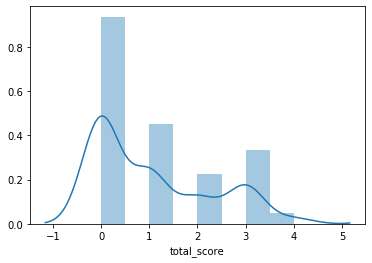

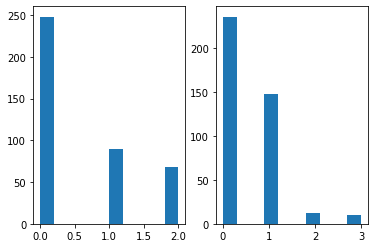

In [90]:
%matplotlib inline
plt.figure()
sns.distplot(F_all.total_score)
fig,ax = plt.subplots(1,2)
a = ax[0].hist(F_all.Tremor)
a = ax[1].hist(F_all.Bradykinesia)

## Other palettes

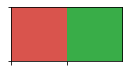

In [45]:
colors = ['pale red','medium green']
sns.palplot(sns.xkcd_palette(colors))